# Topic Modeling on Python

# Context
Twitch is streaming plantform where people from all over the world can stream different activities (gameplays, DIY, concerts and so on) on different languages. There are some streamers more populars on some regions because language and kind of content. In Spain there is a group of streamers that have 
started to stream a new format of soccer. The game consist that 7 players from each team will start playing, but there are some particular cards that can be used by the coach to do things like:
- remove players from the game for some time
- Each goal in a window of time will be count as two.
- Any of the players can be converted as goalkeeper.
- kick a penalty.
- Golden card: where the coach can decide to use any of the special cards.

I just started to follow the Kings League project and decided to analyze the comments on the chat of the day 4 streaming (around 7 hours) where all 6 teams will play for 1 hour to spot the topics that fans where discussing on each game.

# Pre-Processing

In [8]:
import pandas as pd
# Rading data
tabla = pd.read_csv("/home/ereal/Desktop/Master/Text Analytics/Proyecto/twitch-chat-1831494742.csv" , error_bad_lines=False)
# Get number of rows
comentarios_total = len(tabla)
# Delete Null values
tabla.dropna(subset=['message'])


/home/ereal/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3460: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 21940: expected 4 fields, saw 5\nSkipping line 23849: expected 4 fields, saw 5\nSkipping line 26110: expected 4 fields, saw 5\n'


,time,user_name,user_color,message
0,5,d1tp,#000000,vamoooooooooos
1,5,kingjuan200,#FF0000,OPAAAAAAAAAAAAAAAAA
2,5,moobot,#54BC75,Simyo es más fácil que tener a un cactus por ...
3,6,arnodorian230,NaN,por fiiiiiiiiin
4,10,el_gafitas1,#DAA520,1
...,...,...,...,...
48749,23471,xmantekz,#1E90FF,Raid Ibai?
48750,23472,elmadrigamer,#FF7F50,hasta mñn
48751,23472,charly_64_,#1E90FF,@TheGrefg VAMOS QUE SE PUEDE DESCANSA
48752,23472,moobot,#54BC75,kleagueQueensLogo Twitter: https://twitter.co...


In [9]:
# Filter comments made by the user moobot. This was an advertising bot, so it can affect the topic modeling process.
tabla = tabla[(tabla.user_name !="moobot")]
# Get the number of comments after the filter process.
comentarios_filtrado = len(tabla)
# Dataset Summary.
print(f"All Comments: {comentarios_total}")
print(f"Comments Filtered: {comentarios_filtrado}")
print(f"Discarted Comments: {comentarios_total - comentarios_filtrado}")

All Comments: 48754
Comments Filtered: 46824
Discarted Comments: 1930


In [10]:
# Importing libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import math

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

import seaborn as sns


In [11]:
# Method to lematize, convert to lower case and remove stop words from the comments.
import string
from nltk.tokenize import word_tokenize
lemmatizer = nltk.stem.WordNetLemmatizer()

stoplist = stopwords.words('spanish') + list(string.punctuation)
stoplist.append("``")
stoplist.append("''")
stoplist.append("n't")
stoplist.append("'s")
stoplist.append("...")
stoplist.append("--")
stoplist.append("'m") 
stoplist.append("'re")
stoplist.append("Q") 
stoplist.append("..................")
stoplist.append("n.")
stoplist.append("'ve")
stoplist.append("@")
stoplist.append("!")
stoplist.append("<")
#stoplist.append("kleagueescudo")
#stoplist.append("kleaguelogo")

def lemmatize_text(text):
    st = ""
    text = str.lower(str(text))
    tokens = word_tokenize(text)
    tokens_clean = [token for token in tokens if token not in stoplist]
    
    for w in tokens_clean:
        st = st + lemmatizer.lemmatize(w) + " "
    return st

In [12]:
# Before the lemmatize process
tabla.head()

,time,user_name,user_color,message
0,5,d1tp,#000000,vamoooooooooos
1,5,kingjuan200,#FF0000,OPAAAAAAAAAAAAAAAAA
3,6,arnodorian230,NaN,por fiiiiiiiiin
4,10,el_gafitas1,#DAA520,1
5,13,jezuoo98,#DAA520,kleagueEscudo kleagueEscudo kleagueEscudo


In [13]:
# Apply lematize method to all comments
tabla['message'] = tabla['message'].apply(lemmatize_text)

In [14]:
# After the lemmatize process
tabla.head()

,time,user_name,user_color,message
0,5,d1tp,#000000,vamoooooooooos
1,5,kingjuan200,#FF0000,opaaaaaaaaaaaaaaaaa
3,6,arnodorian230,NaN,fiiiiiiiiin
4,10,el_gafitas1,#DAA520,1
5,13,jezuoo98,#DAA520,kleagueescudo kleagueescudo kleagueescudo


# Exploration

## Users with more comments

                  user_name  count
13319           sr_chocolat    591
10935             nox_khada    235
1477              ariiadna_    150
6806             jaguarrr90    128
9888                 matugg    114
12635             samusaezz    100
8614   lapizarrakingsleague     93
13399              stello7x     92
9475               maoh1104     91
231            aarturito011     87


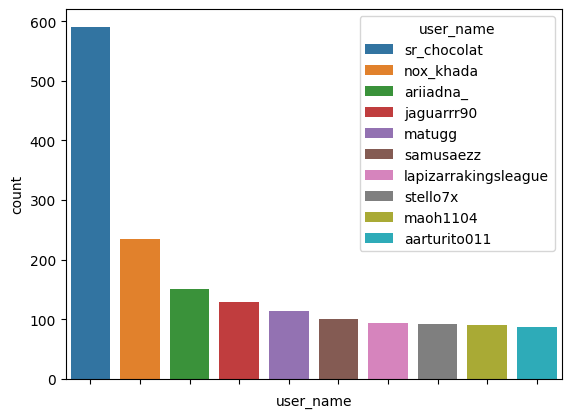

In [9]:
usuarios_mas_comentarios = tabla[['user_name','message']].groupby("user_name")["message"].count().reset_index(name='count').sort_values(['count'], ascending=False) .head(10)
print(usuarios_mas_comentarios)
sns.barplot(data=usuarios_mas_comentarios, x='user_name', y='count', hue='user_name', dodge=False).set(xticklabels=[]);

# Topics

> Separating the comments of each game on kings league day 4. Each game last around 1 hour.

In [15]:
# XBUYER TEAM vs Rivers (16:00 CET)
partido1 = tabla[(tabla["time"]<=5076)]
print(len(partido1))

12236


In [16]:
# Jijantes FC vs Los Troncos FC (17:00 CET)
partido2 = tabla[(tabla["time"]>5076) & (tabla["time"]<=8722)]
print(len(partido2))

7379


In [17]:
# Ultimate Móstoles vs Porcinos FC (18:00 CET)
partido3 = tabla[(tabla["time"]>8722) & (tabla["time"]<=12361)]
print(len(partido3))

8484


In [18]:
# El Barrio vs 1K FC (19:00 CET)
partido4 = tabla[(tabla["time"]>12361) & (tabla["time"]<=15889)]
print(len(partido4))

5706


In [19]:
# Rayo de Barcelona vs Saiyans FC (20:00 CET)
partido5 = tabla[(tabla["time"]>15889) & (tabla["time"]<=19628)]
print(len(partido5))

7243


In [20]:
# Kunisports vs Aniquiladores FC (21:00 CET)
partido6 = tabla[(tabla["time"]>19628) & (tabla["time"]<=23466)]
print(len(partido6))

5765


In [22]:
# Step 3: Building a Topic Model
from gensim import corpora, models
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

def topic_modeling(messages):
    preprocessed_docs = []
    for doc in messages:
        tokens = word_tokenize(doc.lower())
        preprocessed_docs.append(tokens)


    # Create dictionary and corpus
    dictionary = corpora.Dictionary(preprocessed_docs)
    corpus = [dictionary.doc2bow(doc) for doc in preprocessed_docs]

    # Train the LDA model
    lda_model = models.LdaModel(corpus, num_topics=2, id2word=dictionary, passes=10)

    # Interpretation and Visualization of Results
    # Print the topics
    for topic_id, topic in lda_model.print_topics():
        print(f"Topic ID: {topic_id}\nWords: {topic}\n")

    # Visualization of topics using word clouds
    topics = lda_model.show_topics(num_topics=3, num_words=35, formatted=False)

    # Generate word clouds for each topic
    for topic_id, words in topics:
        wordcloud = WordCloud(background_color='white').generate_from_frequencies(dict(words))
        plt.figure(figsize=(8, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f"Topic {topic_id + 1}")
        plt.axis('off')
        plt.show()

# Game 1 - Topics
## XBUYER TEAM vs Rivers (16:00 CET)

Topic ID: 0
Words: 0.048*"mvp" + 0.022*"kleagueescudo" + 0.020*"pio" + 0.019*"biblethump" + 0.016*"arbitro" + 0.016*"footgoal" + 0.015*"puro" + 0.014*"gol" + 0.011*"pinche" + 0.010*"lopo"

Topic ID: 1
Words: 0.057*"lul" + 0.025*"kleaguelogo" + 0.023*"ibairobada" + 0.022*"kleaguepeepoxbuyers" + 0.021*"kleaguepio" + 0.019*"rivers41pio" + 0.018*"kleaguexbuyer" + 0.014*"subscribed" + 0.014*"kleaguepeepopio" + 0.012*"38"



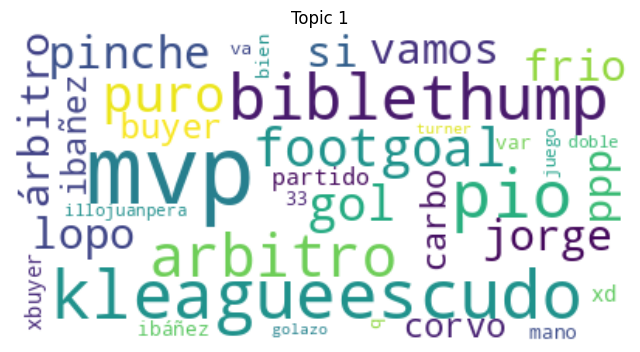

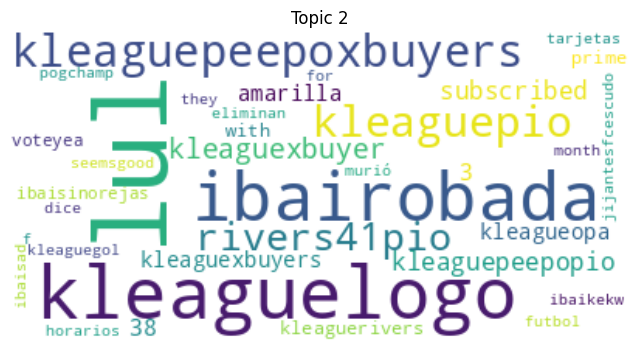

In [23]:
topic_modeling(partido1["message"])

- Context
  - The Pio team is own by a streamer known as Rivers.
  - biblethump is an emoji of twitch's creator.
twitch.
  - Pio team spanish slogan is puro p*nche pio (PPP).
- Results
  - As expected, the topics discussed by fans on this time window is regarding pio and xbuyer teams.
  - More of the fans use emojis like kleaguelogo to show their support.
  - This game was involved on polemics decisiont made by the referee. One of the topics discussed by the fans was about the referee.

# Game 2 - Topics
## Jijantes FC vs Los Troncos FC (17:00 CET)

Topic ID: 0
Words: 0.113*"amen" + 0.072*"amén" + 0.053*"kleaguejijantes" + 0.048*"lul" + 0.029*"kleagueescudo" + 0.021*"kleaguegerardromero" + 0.020*"dios" + 0.019*"jijantes" + 0.017*"ibairobada" + 0.015*"biblethump"

Topic ID: 1
Words: 0.033*"kleaguelogo" + 0.019*"kleaguepeepojijantes" + 0.014*"kleaguegol" + 0.013*"jijantesfcescudo" + 0.012*"jijantes" + 0.011*"kleagueroja" + 0.010*"kleaguelostroncos" + 0.010*"subscribed" + 0.009*"resultados" + 0.008*"diawara"



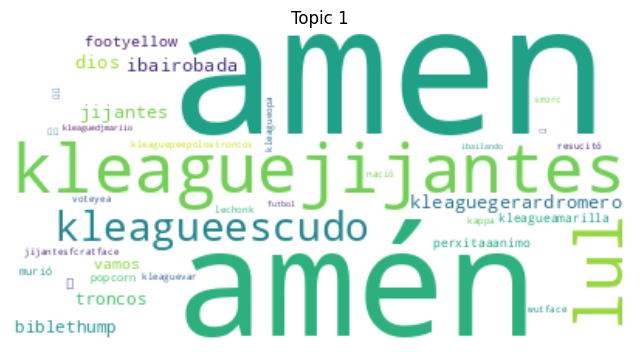

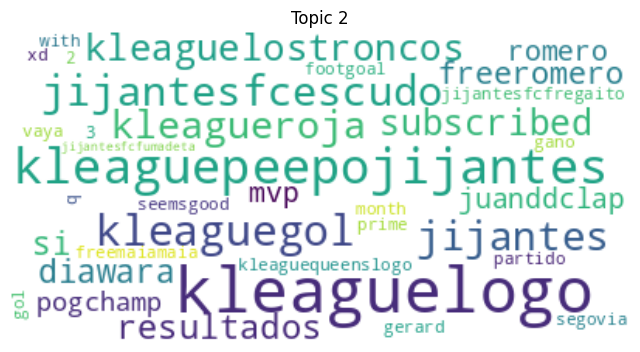

In [26]:
topic_modeling(partido2["message"])


- Context:
  - Jijantes spanish slogan is amen, amen y amen.
  - lul is an emoji to say lol (lot of laugh)
- Results:
  - Many of jijantes fans wrote their slogan (amen, amen and amen) in the chat.
  - We got many subscribers during this game.
  - To show their support, many fans were using emojis like 
    - kleagueescudo .
    - jijantesfcescudo
    - kleaguelostronjos
    - kleaguepeepojijantes

# Game 3 - Topics
## Ultimate Móstoles vs Porcinos FC (18:00 CET)

Topic ID: 0
Words: 0.031*"ibailando" + 0.028*"biblethump" + 0.023*"3" + 0.020*"seemsgood" + 0.017*"mostoles" + 0.015*"kleaguepeepoporcinos" + 0.013*"kleagueultimatemostoles" + 0.013*"jijantesfcescudo" + 0.012*"kleaguequeenslogo" + 0.012*"kleaguedjmariio"

Topic ID: 1
Words: 0.071*"lul" + 0.037*"ibaipeeporcino" + 0.026*"porcinos" + 0.024*"kleagueporcinos" + 0.019*"ibaiporcinosfc" + 0.018*"mvp" + 0.014*"league" + 0.012*"resultados" + 0.011*"guti" + 0.010*"cichero"



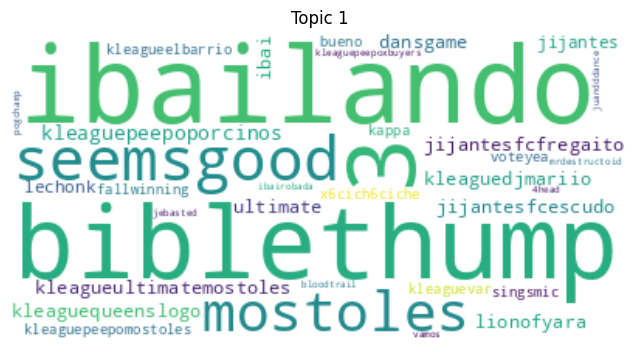

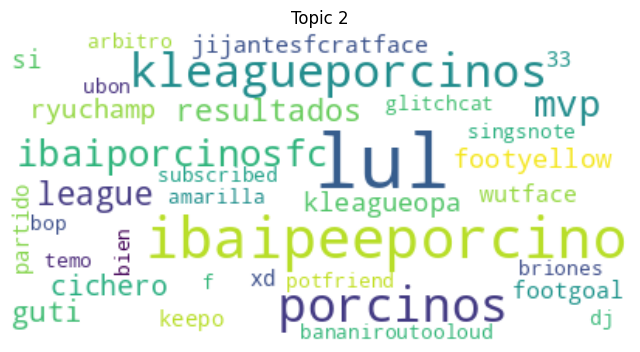

In [62]:
topic_modeling(partido3["message"])

- Context:
  - One of the start streamers of the Kings League is the known gamer Ibai. His team name is porcinos.
  - biblethump is an emoji of twitch's creator.
  - iabilando is an emoji of Ibai dancing.
- Results
  - To show their support, many fans were using emojis like 
    - ibailando
    - biblethump 
  - Ibais team "porcinos" was one the most supported by fans.
  - The word "yellow" (spanish amarillo) was one most used by fans. That could mean that this game was involved in polemics because some game actions.

# Game 4 - Topics
## El Barrio vs 1K FC (19:00 CET)

Topic ID: 0
Words: 0.016*"1k" + 0.015*"kleaguequeenslogo" + 0.014*"gilles" + 0.014*"si" + 0.013*"kleagueelbarrio" + 0.012*"mvp" + 0.010*"xd" + 0.009*"3" + 0.009*"fajardo" + 0.008*"penal"

Topic ID: 1
Words: 0.074*"lul" + 0.028*"resultados" + 0.022*"barrio" + 0.020*"biblethump" + 0.011*"kleaguepeepoelbarrio" + 0.010*"knesleeper" + 0.009*"ibaikekw" + 0.008*"vamos" + 0.007*"f" + 0.007*"seemsgood"



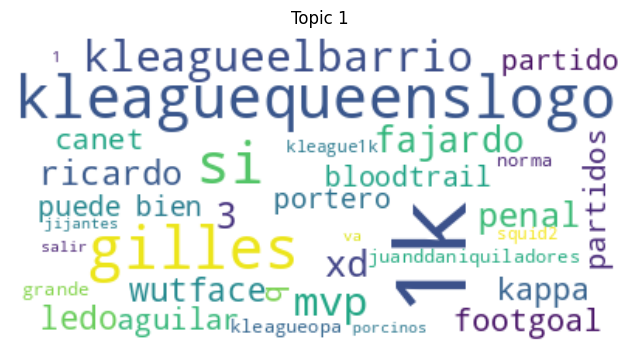

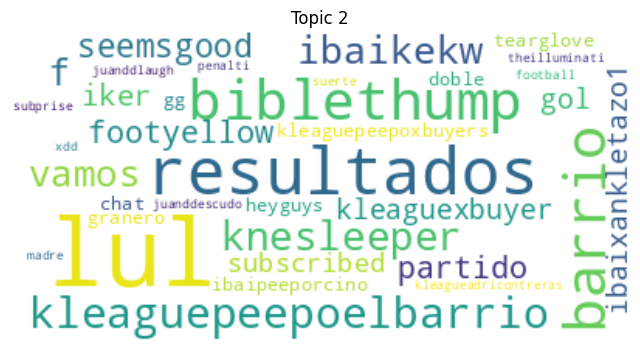

In [63]:
topic_modeling(partido4["message"])

- Context:
  - The kings league has their own emojis like
    - kleagueopa
    - kleaguerayodebarcelona  
- Results
  - The team "El barrio" was one of the most supported by fans.
  - The slang "Chankletazo" means that some players had a clear opportunity to score and they send the ball to sky. It could be infered that on some penal or clear goal action the player missed his chance.

# Game 5 - Topics
## Rayo de Barcelona vs Saiyans FC (20:00 CET)

Topic ID: 0
Words: 0.078*"mvp" + 0.046*"edgar" + 0.034*"dani" + 0.025*"lul" + 0.019*"repitan" + 0.014*"footgoal" + 0.012*"encuesta" + 0.012*"si" + 0.008*"rayo" + 0.008*"vamos"

Topic ID: 1
Words: 0.017*"kleagueopa" + 0.017*"kleaguerayodebarcelona" + 0.012*"resultados" + 0.012*"kleaguesaiyans" + 0.012*"golazo" + 0.011*"xd" + 0.007*"kleaguegol" + 0.007*"voteyea" + 0.007*"votacion" + 0.007*"kleaguepeeporayodebarcelona"



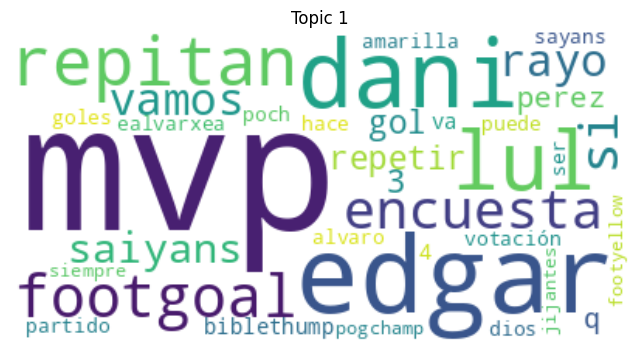

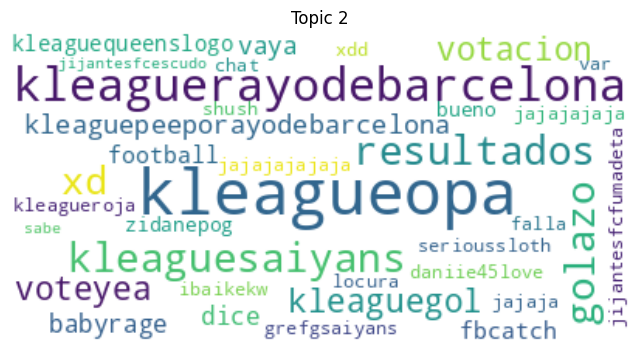

In [64]:
topic_modeling(partido5["message"])

- Context:
  - MVP means most valuable player.
  - The kings league has their own emojis like
    - kleagueopa
    - kleaguerayodebarcelona  
- Results
  - The word repeat (spanish repitan) was used several times. It could be infered that there were some polemics actions on some game actions.
  - The word mvp was one of the most used by the fans (along with some names), that could indicate there is an excepcional soccer player on of the teams.
  - Most of the kings league fans shows their support using emojis.

# Topicos Partido #6
## Kunisports vs Aniquiladores FC (21:00 CET)

Topic ID: 0
Words: 0.032*"juanddaniquiladores" + 0.029*"kleagueaniquiladores" + 0.020*"3" + 0.018*"4" + 0.014*"footyellow" + 0.013*"aniquiladores" + 0.010*"juanddescudo" + 0.009*"mvp" + 0.008*"vamos" + 0.008*"kleagueopa"

Topic ID: 1
Words: 0.047*"lul" + 0.031*"kleaguepeepoaniquiladores" + 0.021*"footgoal" + 0.016*"resultados" + 0.016*"seemsgood" + 0.014*"fran" + 0.014*"slakunkunisports" + 0.012*"xd" + 0.012*"kleaguejuansguarnizo" + 0.011*"coro"



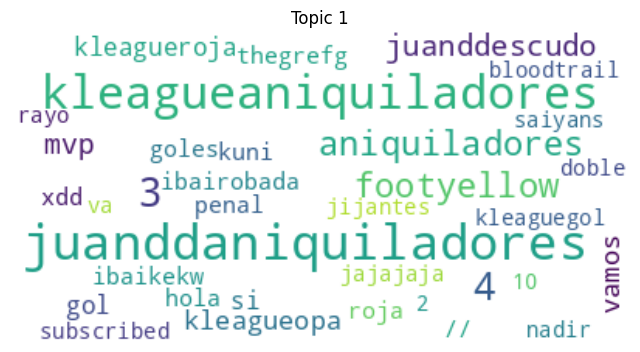

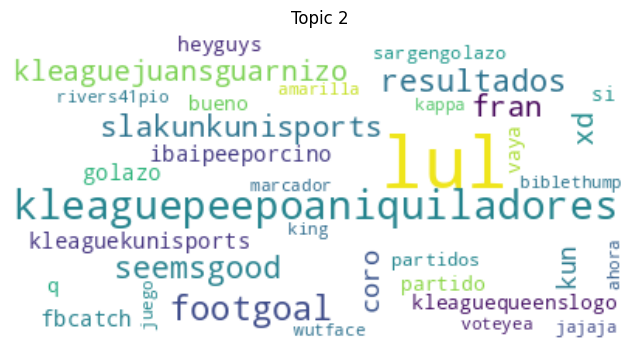

In [65]:
topic_modeling(partido6["message"])

- Context:
  - The well known streamer Juan Garnizo is the owner of Aniquiladores team.
  - The well known streamer and former professional soccer player Kun Aguero is the owner of Kunisports team.
- Results
  - The word golazo (slang word used to indicate an incredible goal) could indicate that there was an incredible goal scored during this game.
  - Aniquiladores team was one of the most supported.
  - One of the topics discussed by the fans was penal (penalty), that could mean that there is some polemic around a game action where the referee didnt gave a penalty to one of the teams.

# Topics on the Kings league day 4

Topic ID: 0
Words: 0.052*"lul" + 0.037*"kleaguelogo" + 0.029*"juanddaniquiladores" + 0.020*"resultados" + 0.017*"kleaguepeepoaniquiladores" + 0.017*"edgar" + 0.016*"kleagueaniquiladores" + 0.015*"4" + 0.013*"footyellow" + 0.012*"vamos"

Topic ID: 1
Words: 0.024*"mvp" + 0.023*"kleagueescudo" + 0.017*"3" + 0.011*"footgoal" + 0.011*"si" + 0.010*"dani" + 0.009*"xd" + 0.008*"aniquiladores" + 0.007*"biblethump" + 0.007*"partido"



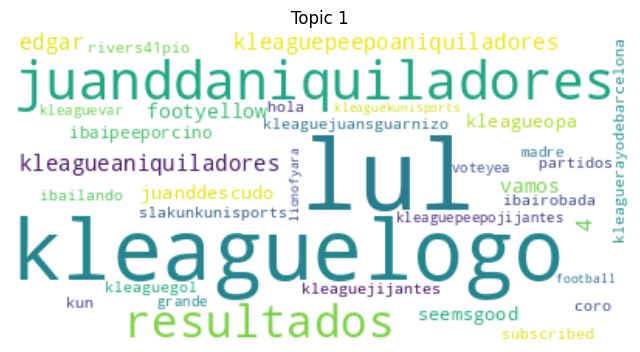

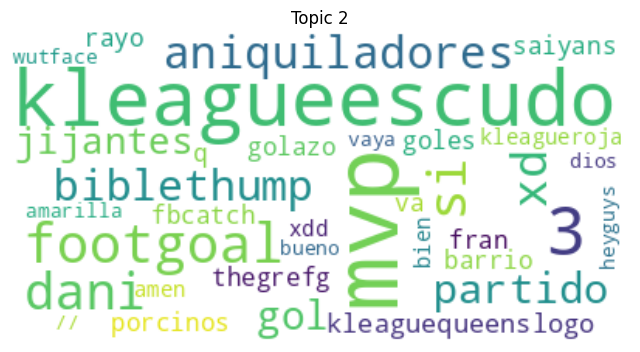

In [24]:
topic_modeling(tabla["message"])


- Results
  - Most of the kings league fans shows their support using emojis.
  - Aniquiladores team was one of the most supported by fans.